# eda

In [3]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from dotenv import load_dotenv
load_dotenv
sys.path.append(os.getenv('UTILS_PATH'))
from tqdm import tqdm
import multiprocessing
import inspect

import pandas as pd
import polars as pl
import numpy as np
import itertools
import cudf
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import line_notify
import my_logger
from noglobal import noglobal

# 設定

In [4]:
@dataclass
class Cfg:
    loglevel = "INFO"
    exp_name = "ensemble001"
    run_inf = True
    seed = 42
    k = 20
    cand_n = 15
    negative_sample = 1
    train_chunk_n_dict = {"clicks":2, "carts":1, "orders":1}
    test_chunk_n = 5
    type2id = {"clicks":0, "carts":1, "orders":2}
    id2type = {0:"clicks", 1:"carts", 2:"orders"}
    train_week = "week3"
    valid_week = "week4"
    valid_session_n = 100_000
    input_dir = os.getenv('INPUT_DIR')
    output_dir = os.getenv('OUTPUT_DIR')
    prep_dir = os.getenv("PREP_DIR")

    clicks_params = {'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.1, 'metric': 'binary_logloss', 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 5.485903737168179, 'lambda_l2': 0.005594683492536064, 'num_leaves': 79, 'feature_fraction': 0.552, 'bagging_fraction': 0.9295272232672004, 'bagging_freq': 2, 'min_child_samples': 10}
    carts_params = {'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.1, 'metric': 'binary_logloss', 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 8.709050252544463, 'lambda_l2': 0.06935262036337767, 'num_leaves': 252, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5}
    orders_params = {'objective': 'binary', 'boosting': 'gbdt', 'learning_rate': 0.1, 'metric': 'binary_logloss', 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 9.356310279757256, 'lambda_l2': 1.3120983078968551e-08, 'num_leaves': 174, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}

cfg = Cfg()
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)
random.seed(cfg.seed)

logger = my_logger.init_logger(cfg.exp_name)

In [5]:
subs = {
    #"t88_053": cfg.output_dir + f"exp053_pl/t88_exp053_pl_sub_k30.csv", 
    #"t88_059": cfg.output_dir + f"exp059/t88_exp059_sub_k30.csv", 
    #"t88_cp001": cfg.output_dir + f"cherrypick001/t88_cherrypick001_sub_k30.csv",
    #"t88_062": cfg.output_dir + f"exp062/t88_exp062_sub_k30.csv",
    "t88_063": cfg.output_dir + f"exp063/t88_exp063_sub_k30.csv",
    "t88_en003": cfg.output_dir + f"ensemble003/t88_ensemble003_sub_k30.csv",
    "deho_en002": "/mnt/otto-recommender-system/subs/deho_catboost_ensemble_002.csv",
    "chi_400": "/mnt/otto-recommender-system/subs/chi_exp400.csv",
    #"zako_030": "/mnt/otto-recommender-system/subs/zako_030_lgbm_rank_stacking_sub_30.csv"
    }

In [6]:
sub = pd.read_csv(subs["t88_en003"]).sort_values("session_type", ignore_index=True)

In [8]:
sub["labels"] = sub["labels"].apply(lambda x: x.split())

In [12]:
sub = sub.explode(column="labels")

In [13]:
sub["labels"].value_counts()

1460571    92511
108125     82334
166037     79402
620545     77879
1022566    69899
           ...  
1577161        1
1594444        1
1168466        1
1082658        1
1238138        1
Name: labels, Length: 1497468, dtype: int64

In [14]:
test_sessions = pd.read_parquet(cfg.prep_dir + f"test_sessions.parquet")

In [19]:
test_sessions["ts"] = pd.to_datetime(test_sessions["ts"],unit="ms")

<AxesSubplot: >

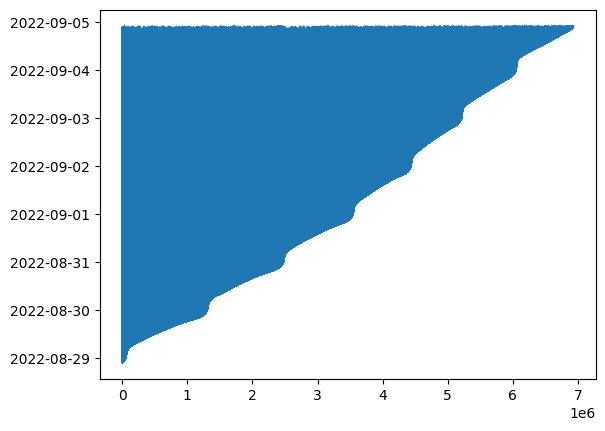

In [27]:
test_sessions["ts"].plot()

<AxesSubplot: >

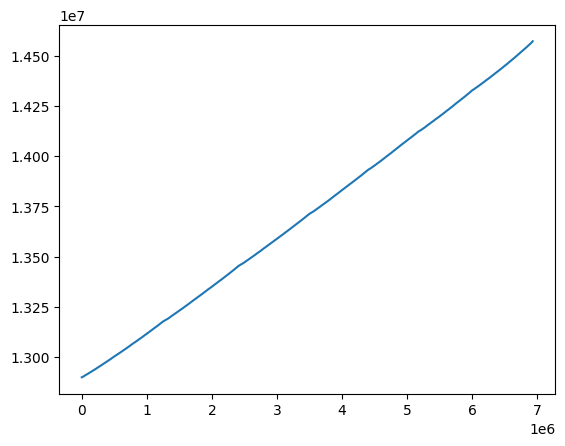

In [30]:
test_sessions["session"].plot()

In [40]:
test_sessions["day"] = test_sessions["ts"].dt.date

In [45]:
agg = test_sessions.groupby(["aid", "type", "day"])["session"].count().reset_index()
agg.columns = ["aid", "type", "day", "cnt"]

In [52]:
agg["total_cnt"] = agg.groupby("aid")["cnt"].transform("sum")

In [56]:
agg.sort_values(["total_cnt", "aid", "type", "day"], ascending=(False, True, True, True)).to_csv(cfg.output_dir + "eda002.csv", index=False)

In [19]:
for i, (name, file_path) in enumerate(zip(subs.keys(), subs.values())):
    print(name)
    if i == 0:
        sub = pd.read_csv(file_path).sort_values("session_type", ignore_index=True)
        sub.columns = ['session_type', name]
        sub[name] = sub[name].apply(lambda x: x.split())
    else:
        sub[name] = pd.read_csv(file_path).sort_values("session_type", ignore_index=True)['labels'].apply(lambda x: x.split())

t88_063
t88_en003
deho_en002
chi_400


In [20]:
types = []
sub1s = []
sub2s = []
sims = []
for type_ in ["clicks", "carts", "orders"]:
    type_sub = sub[sub["session_type"].str.contains(type_)]
    for sub1_name, sub2_name in itertools.combinations(subs.keys(), 2):
        print(type_, sub1_name, sub2_name)
        tmp = []
        for sub1, sub2 in tqdm(zip(type_sub[sub1_name].tolist(), type_sub[sub2_name].tolist()), total=len(type_sub)):
            sub1, sub2 = set(sub1[:20]), set(sub2[:20])
            tmp.append(len(sub1 & sub2) / 20)
        types.append(type_)
        sub1s.append(sub1_name)
        sub2s.append(sub2_name)
        sims.append(np.mean(tmp))
        print(np.mean(tmp))

clicks t88_063 t88_en003


100%|██████████| 1671803/1671803 [00:07<00:00, 212068.95it/s]


0.9313262687051048
clicks t88_063 deho_en002


100%|██████████| 1671803/1671803 [00:06<00:00, 239349.16it/s]


0.6943202937188178
clicks t88_063 chi_400


100%|██████████| 1671803/1671803 [00:06<00:00, 248393.38it/s]


0.7355661223242211
clicks t88_en003 deho_en002


100%|██████████| 1671803/1671803 [00:06<00:00, 257966.91it/s]


0.7039703840703718
clicks t88_en003 chi_400


100%|██████████| 1671803/1671803 [00:06<00:00, 265320.56it/s]


0.7441229020404916
clicks deho_en002 chi_400


100%|██████████| 1671803/1671803 [00:06<00:00, 270777.97it/s]


0.7044401463569575
carts t88_063 t88_en003


100%|██████████| 1671803/1671803 [00:07<00:00, 212163.61it/s]


0.9324702731123228
carts t88_063 deho_en002


100%|██████████| 1671803/1671803 [00:06<00:00, 242508.99it/s]


0.681261428529558
carts t88_063 chi_400


100%|██████████| 1671803/1671803 [00:06<00:00, 249394.99it/s]


0.7025572391005402
carts t88_en003 deho_en002


100%|██████████| 1671803/1671803 [00:06<00:00, 254710.25it/s]


0.6900579195036736
carts t88_en003 chi_400


100%|██████████| 1671803/1671803 [00:06<00:00, 269559.12it/s]


0.710645482751257
carts deho_en002 chi_400


100%|██████████| 1671803/1671803 [00:06<00:00, 268960.70it/s]


0.6809141388070242
orders t88_063 t88_en003


100%|██████████| 1671803/1671803 [00:07<00:00, 211115.75it/s]


0.9567457708832914
orders t88_063 deho_en002


100%|██████████| 1671803/1671803 [00:06<00:00, 248199.61it/s]


0.6725276542750549
orders t88_063 chi_400


100%|██████████| 1671803/1671803 [00:06<00:00, 252101.90it/s]


0.6896445932923908
orders t88_en003 deho_en002


100%|██████████| 1671803/1671803 [00:06<00:00, 262309.62it/s]


0.6779722251963899
orders t88_en003 chi_400


100%|██████████| 1671803/1671803 [00:06<00:00, 271929.88it/s]


0.6948016901512918
orders deho_en002 chi_400


100%|██████████| 1671803/1671803 [00:06<00:00, 277683.64it/s]


0.6684596809552327


In [21]:
result = pd.DataFrame({"type":types, "sub1":sub1s, "sub2":sub2s, "sim":sims})
result = result.append(result.rename(columns={"sub1":"sub2", "sub2":"sub1"}))
for type_ in ["clicks", "carts", "orders"]:
    result = result.append(pd.DataFrame({"type":[type_ for _ in range(len(subs.keys()))], 
                                        "sub1":subs.keys(),
                                        "sub2":subs.keys(),
                                        "sim":[1.0 for _ in range(len(subs.keys()))]}))
result = result.sort_values(["sub1", "sub2"])

/tmp/ipykernel_27583/2956869052.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(result.rename(columns={"sub1":"sub2", "sub2":"sub1"}))
/tmp/ipykernel_27583/2956869052.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame({"type":[type_ for _ in range(len(subs.keys()))],
/tmp/ipykernel_27583/2956869052.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame({"type":[type_ for _ in range(len(subs.keys()))],
/tmp/ipykernel_27583/2956869052.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.DataFrame({"type":[type_ for _ i

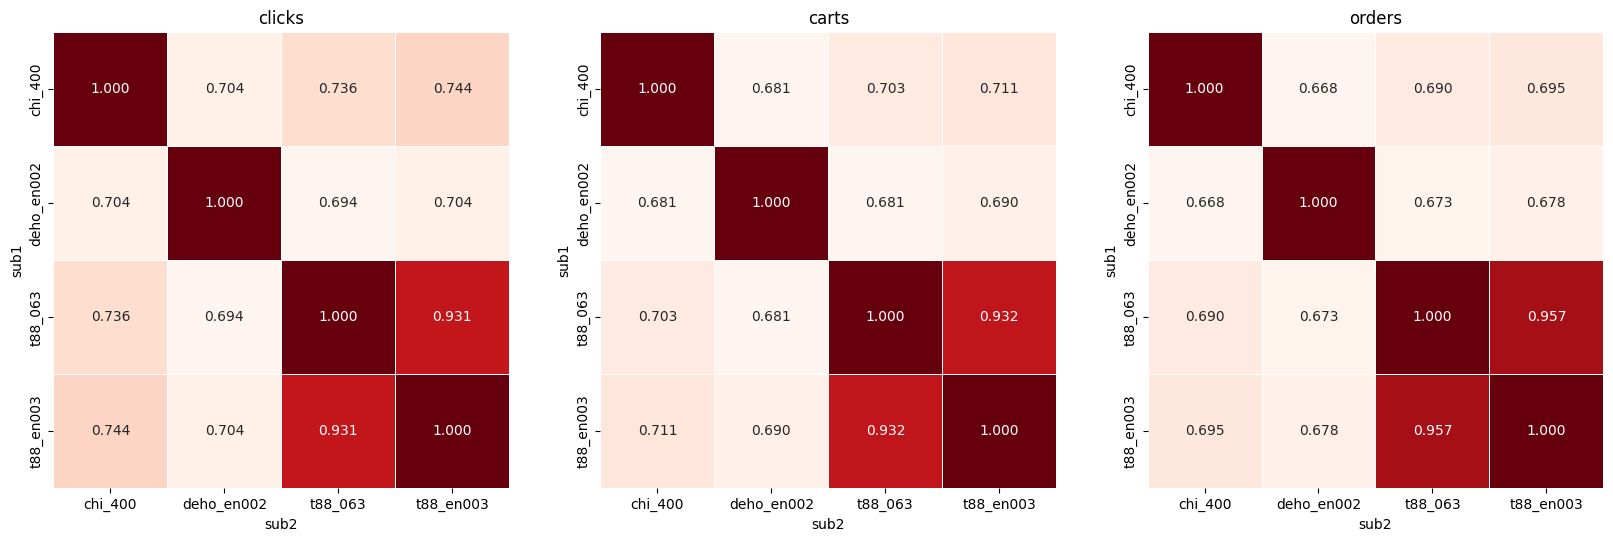

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(20,10))
for i, type_ in enumerate(["clicks", "carts", "orders"]):
    type_result = result[result["type"]==type_][["sub1", "sub2", "sim"]]
    type_result = pd.pivot(data=type_result, index="sub1", columns="sub2", values="sim")
    sns.heatmap(type_result, annot=True, fmt="1.3f", cmap="Reds", ax=axes[i], square=True, linewidths=0.5, cbar=False)
    axes[i].set_title(type_)